In [1]:
import numpy as np
import pandas as pd
import xgboost
import time
import os
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

/Users/zgubic/anaconda3/envs/py27/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [ ]:
ds_train = pd.read_hdf('../data/DS_2_train_extended_float32.hdf')

In [2]:
ds_train = pd.read_hdf('../data/DS_2_train_extended_float32.hdf')

up_dists = ['dR'+str(i)+'up' for i in range(1,6)]
down_dists = ['dR'+str(i)+'down' for i in range(1,6)]
dists = up_dists+down_dists
up_angles = ['dT'+str(i)+'up' for i in range(1,6)]
down_angles = ['dT'+str(i)+'down' for i in range(1,6)]
angles = up_angles + down_angles
grid = ['grid_value', 'smoothgrid_value']

ds_train.head()
ds_train.drop(angles+grid, axis=1, inplace=True)
ds_train.head()

,index,event_id,X,Y,Z,TX,TY,chi2,signal,brick_number,...,dR1up,dR1down,dR2up,dR2down,dR3up,dR3down,dR4up,dR4down,dR5up,dR5down
0,0,-999,66162.843750,65620.031250,0.0,0.166890,0.276674,2.988714,0.0,44,...,-999.000000,412.241272,-999.000000,248.789047,-999.000000,553.542969,-999.000000,698.970520,-999.000000,244.996826
1,1,-999,43900.445312,67091.671875,0.0,-0.179967,-0.478795,1.901420,0.0,98,...,-999.000000,1219.330688,-999.000000,909.134155,-999.000000,508.946655,-999.000000,524.939331,-999.000000,642.560852
2,2,-999,37564.019531,26618.890625,55599.0,-0.267820,-0.282087,2.510245,0.0,64,...,831.191528,429.726746,519.746033,179.646698,1469.534790,831.921570,800.664490,1088.205444,887.107056,363.055908
3,3,-999,39380.027344,48135.425781,19395.0,0.265197,-0.577493,1.215219,0.0,63,...,217.105438,772.216370,898.697327,732.458069,567.273071,684.447266,841.417786,1224.376221,413.581573,1006.183350
4,4,-999,65040.781250,44018.468750,12930.0,-0.711161,-0.245592,2.973661,0.0,2,...,449.162842,1232.191406,781.930542,741.583557,1040.501587,420.205811,701.071167,805.463928,238.712112,1295.326904


,index,event_id,X,Y,Z,TX,TY,chi2,signal,brick_number,dR1up,dR1down,dR2up,dR2down,dR3up,dR3down,dR4up,dR4down,dR5up,dR5down
0,0,-999,66162.843750,65620.031250,0.0,0.166890,0.276674,2.988714,0.0,44,-999.000000,412.241272,-999.000000,248.789047,-999.000000,553.542969,-999.000000,698.970520,-999.000000,244.996826
1,1,-999,43900.445312,67091.671875,0.0,-0.179967,-0.478795,1.901420,0.0,98,-999.000000,1219.330688,-999.000000,909.134155,-999.000000,508.946655,-999.000000,524.939331,-999.000000,642.560852
2,2,-999,37564.019531,26618.890625,55599.0,-0.267820,-0.282087,2.510245,0.0,64,831.191528,429.726746,519.746033,179.646698,1469.534790,831.921570,800.664490,1088.205444,887.107056,363.055908
3,3,-999,39380.027344,48135.425781,19395.0,0.265197,-0.577493,1.215219,0.0,63,217.105438,772.216370,898.697327,732.458069,567.273071,684.447266,841.417786,1224.376221,413.581573,1006.183350
4,4,-999,65040.781250,44018.468750,12930.0,-0.711161,-0.245592,2.973661,0.0,2,449.162842,1232.191406,781.930542,741.583557,1040.501587,420.205811,701.071167,805.463928,238.712112,1295.326904


In [3]:
X_full = ds_train.copy()
X_full = X_full.drop('index', axis=1).drop('event_id', axis=1).drop('signal', axis=1)

brick_nb = 80
X_train = X_full[X_full.brick_number != brick_nb].drop('brick_number', axis=1)
X_test = X_full[X_full.brick_number == brick_nb].drop('brick_number', axis=1)

Y_train = ds_train[ds_train.brick_number != brick_nb]['signal']
Y_test = ds_train[ds_train.brick_number == brick_nb]['signal']

SID_train = ds_train[ds_train.brick_number != brick_nb]['event_id']
SID_test = ds_train[ds_train.brick_number == brick_nb]['event_id']

In [4]:
n_est = 8

#model = xgboost.XGBClassifier(n_estimators=n_est, nthread=8, max_depth=2)#, reg_alpha=0, reg_lambda=0.5)
#model = GradientBoostingClassifier(n_estimators=n_est, max_depth=4, loss='exponential')
model = RandomForestClassifier(n_estimators=n_est, max_depth=3, n_jobs=8)
#model = xgboost.XGBClassifier(n_estimators=n_est, nthread=8, max_depth=3)

t1= time.time()
model.fit(X_train, Y_train)
pred_train = model.predict_proba(X_train)[:,1]
pred_test = model.predict_proba(X_test)[:,1]
print 'n_est:', n_est
print 'time taken:', time.time() - t1
print 'train score:', roc_auc_score(Y_train, pred_train)
print 'test score:', roc_auc_score(Y_test, pred_test)
os.system('say "dataset evaluated"')

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=3, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=8, n_jobs=8, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

n_est: 8
time taken: 45.9863529205
train score: 0.955132234831
test score: 0.975829148363


0

In [5]:
df = X_test.copy()
df['signal'] = Y_test
df['prediction'] = pred_test
df.head()

,X,Y,Z,TX,TY,chi2,dR1up,dR1down,dR2up,dR2down,dR3up,dR3down,dR4up,dR4down,dR5up,dR5down,signal,prediction
66,63412.230469,56497.328125,18102.0,-0.163839,0.170926,2.202520,262.035156,625.499268,380.311493,570.891907,1039.079590,198.765228,1283.271118,473.968231,487.958374,122.039360,0.0,0.003743
69,47022.214844,31809.193359,55599.0,-0.020517,0.326897,1.855748,1086.859009,1074.467896,531.549927,880.713562,220.959518,1005.565002,185.008377,313.402435,314.781433,784.578247,0.0,0.004604
173,68146.601562,60375.234375,72408.0,-0.190253,0.491592,2.642660,313.342346,-999.000000,433.955261,-999.000000,747.656799,-999.000000,625.677673,-999.000000,971.589294,-999.000000,0.0,0.016945
241,27993.085938,36181.382812,58185.0,-0.351009,0.160584,2.021488,815.442261,1096.096802,961.650879,1916.012695,551.217407,2693.097412,203.946609,2332.650146,673.640686,2978.132812,0.0,0.004604
286,49905.347656,13766.968750,37497.0,-0.522935,-0.177130,2.788963,549.840210,590.554993,1193.074097,364.858063,1046.644165,907.870850,5.546541,658.669922,480.191956,770.300415,0.0,0.003071


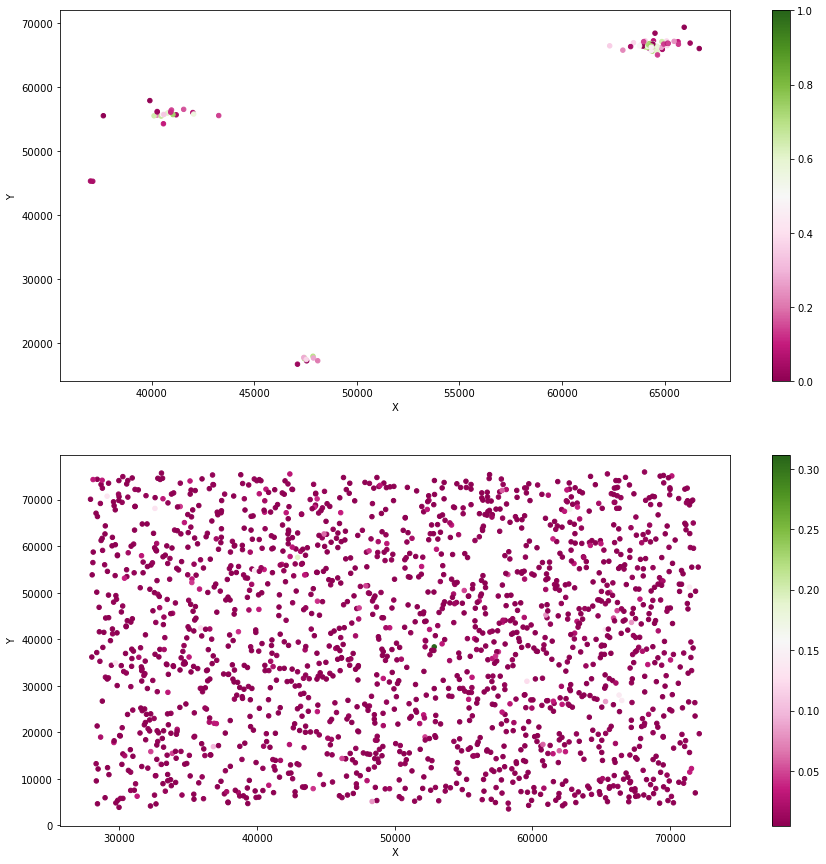

In [7]:
# basic plots
fig, ax = plt.subplots(2, figsize=(15, 15))

sig = df[df.signal == 1]
bkg = df[df.signal == 0]

nlayer = 45
sig = sig[sig.Z == nlayer*1293]
bkg = bkg[bkg.Z == nlayer*1293]

sig.plot.scatter('X', 'Y', c=sig.prediction, cmap='PiYG', vmin=0, vmax=1, alpha = 1, ax=ax[0])
bkg.plot.scatter('X', 'Y', c=bkg.prediction, cmap='PiYG', alpha = 1, ax=ax[1])
plt.show()